In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import helpers.utils as utils
import tqdm
import helpers.structured as structured
from sklearn.metrics.pairwise import cosine_similarity
from helpers.constants import TREATMENT_LABEL, CONTROL_LABEL

In [ ]:
users_df, events_df, tasks_df, suggestions_df = utils.final_data_prep()
dfp = tasks_df.copy()
print(f"Number of participants: {len(users_df)}")

# To ensure that the order of countries is consistent across plots
countries = sorted(tasks_df['country'].unique())
groups = [CONTROL_LABEL, TREATMENT_LABEL]

### Grammar check (number of grammar errors in Indian and American texts)

In [3]:
import language_tool_python

# Initialize LanguageTool for English
tool = language_tool_python.LanguageTool('en-US')

In [26]:
x = """My favorite celebrity is Sadh Guru because of his wisdom and teachings. His insights on life are transformative. whenever I feel lost, his guidance helps. i want to share his teachings with others. i want to meet him one day and thank him. may god bless him always. may his message reach more people."""
m = tool.check(x)
m = [mi for mi in m if mi.category not in ['CASING', 'TYPOS', 'REPETITIONS_STYLE']]
m

[]

In [ ]:
# Playing around with the language tool
msgs = []

for essay in tqdm.tqdm(dfp.finalHtml_stripped):
    m = tool.check(essay)
    # m = [mi for mi in m if mi.category == 'TYPOGRAPHY']# not in ['CASING', 'TYPOS', 'REPETITIONS_STYLE', 'CONSECUTIVE_SPACES']]
    match_messages = []
    for match in m:
        match_messages.append((essay, match, match.category))
    msgs += match_messages
    # if len(m) > 0:
    #     import ipdb; ipdb.set_trace()

t = pd.DataFrame(msgs, columns=['essay', 'match', 'category'])

In [ ]:
i = 5
print(t[t.category == 'GRAMMAR'].iloc[i].match)
print(t[t.category == 'GRAMMAR'].iloc[i].essay)

In [ ]:
t.category.value_counts().sort_values(ascending=False).head(10)

In [11]:
# Real stuff
def grammar_check(x):
    m = tool.check(x)
    m = [mi for mi in m if mi.category not in ['TYPOS']]
    return m

dfp['num_errors'] = dfp['finalHtml_stripped'].apply(lambda x: len(grammar_check(x)))

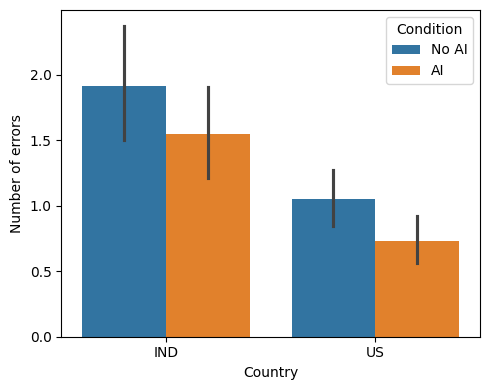

In [12]:
plt.figure(figsize=(5, 4))
sns.barplot(x='country', y='num_errors', hue='group', hue_order=groups, data=dfp, order=countries)
plt.xlabel('Country')
plt.ylabel('Number of errors')
plt.legend(title='Condition')
plt.tight_layout()
plt.savefig('plots/grammatical_errors.png')

In [8]:
# Perform statistical tests
dft = dfp[dfp.country == 'US']

df_normality = utils.perform_normality_test(dft, ["num_errors"], filter_col='group', filter_vals=groups)
display(df_normality)

df_stats = utils.perform_statistical_test(dft, ["num_errors"], filter_col='group', filter_vals=groups, test_name='mannwhitney')
display(df_stats)

,col,shapiro_No AI,shapiro_AI,shapiro_No AI_interpretation,shapiro_AI_interpretation
0,num_errors,2.839023e-11,4.325659e-13,Not normal,Not normal


,col,u_stat,p_value,cliffs_d,significant
0,num_errors,7729.000000,0.035429,0.148781,True


### Analyze artifacts (food/movies/festivals)
First, we will make calls to OpenAI to extract structured data from the essays. Then, we will analyze the text.

In [11]:
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv
import os

load_dotenv()

model = AzureChatOpenAI(
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_deployment=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"],
)

In [6]:
task_id = 'public_figure'
dft = structured.extract_structured_data_from_tasks(task_id, dfp[dfp['id'] == task_id], model, quiet=False)
dft

118it [00:00, 1766.74it/s]


,name,artifact_country,profession,artifact_country_binned
p-6632f19311dacff691b822a0,Shah Rukh Khan,India,actor,India
p-65f334069b13487e9bba446a,Keanu Reeves,Canada,actor,Other
p-66321cfc446914f3b199e193,Sadh Guru,India,spiritual leader,India
p-664b876ebe0680d014a1c471,A.P.J. Abdul Kalam,India,"scientist, politician",India
p-65f3e10620fcdc20351a4295,A.R. Rahman,India,musician,India
...,...,...,...,...
p-669acb04333f2cb18b8985c4,Nicki Minaj,US,singer,Other
p-5f24b0fc546c5a0c3c2e43b6,Barack Obama,US,politician,Other
p-66b570b96f482e66fde8fef3,Nelson Mandela,South Africa,politician,Other
p-66b4282a76f9d01e64dee065,Maia Mitchell,US,actor,Other


In [16]:
# See which festivals were mentioned by Indians and Americans
dftt = dft.join(users_df[['country', 'group']])
dftt[(dftt.country == 'US') & (dftt.group == CONTROL_LABEL)].groupby('name').size().sort_values(ascending=False)

name
Taylor Swift                   3
Adam Sandler                   2
Kamala Harris                  2
Morgan Freeman                 1
celebrity                      1
celebrities                    1
Tom Cruise                     1
Shaquille O'Neal               1
Ronaldo                        1
Rihanna                        1
None                           1
Nelson Mandela                 1
Nassim Nicholas Taleb          1
Mariah Carey                   1
Ann Richards                   1
Maia Mitchell                  1
Lil Wayne                      1
Keanu Reeves                   1
Joe Biden                      1
David Lynch                    1
Dak Prescott                   1
Cristiano Ronaldo              1
Bernie Sanders                 1
Ariana Grande                  1
lead singer of The National    1
dtype: int64

In [ ]:
dftt[dftt.country == 'US']

In [ ]:
task_id = 'food'

# Bootstrap to get a distribution of proportion of essays with Indian vs US public figures
proportion_ind_noai = []
proportion_ind_ai = []

for _ in tqdm.tqdm(range(100)):
    dft = dfp[dfp['id'] == task_id].sample(frac=0.8, replace=True)
    df_structured = structured.extract_structured_data_from_tasks(task_id, dft, model, quiet=True)
    df_structured = dft[['user_id', 'country', 'group']].join(df_structured, on='user_id', rsuffix='_essay')

    # Calculate the counts
    counts = df_structured.groupby(['country', 'group', 'artifact_country_binned']).size().reset_index(name='count')
    # Calculate the proportions
    counts['proportion'] = counts['count'] / counts.groupby(['country', 'group'])['count'].transform('sum')
    counts = counts.set_index(['country', 'group', 'artifact_country_binned'])
    # Get the proportion of essays with Indian and US public figures
    proportion_ind_noai.append(counts.loc['IND', CONTROL_LABEL, 'India']['proportion'])
    proportion_ind_ai.append(counts.loc['IND', TREATMENT_LABEL, 'India']['proportion'])

In [ ]:
stats.ttest_ind(proportion_ind_noai, proportion_ind_ai), utils.cohens_d(proportion_ind_noai, proportion_ind_ai)

In [ ]:
sns.barplot({'No AI': proportion_ind_noai, 'AI': proportion_ind_ai})
label = 'festivals' if task_id == 'festival' else 'public figures'
plt.title(f'Proportion of essays with Indian {label}')
plt.show()

In [ ]:
# Plot the data for a specific task
task_id = 'festival'
dft = dfp[dfp['id'] == task_id].sample(frac=0.8, replace=True)
df_structured = structured.extract_structured_data_from_tasks(task_id, dft, model, quiet=True)
df_structured = dft[['user_id', 'country', 'group']].join(df_structured, on='user_id', rsuffix='_essay')

# Calculate the counts
counts = df_structured.groupby(['country', 'group', 'artifact_country_binned']).size().reset_index(name='count')
# Calculate the proportions
counts['proportion'] = counts['count'] / counts.groupby(['country', 'group'])['count'].transform('sum')

sns.catplot(x='country', y='proportion', hue='artifact_country_binned', data=counts, kind='bar', col='group', col_order=groups, order=countries)

In [ ]:
# Pivot the data to prepare for a stacked bar plot
df_pivot = counts.pivot_table(index='group', columns=['country', 'artifact_country_binned'], values='proportion').fillna(0)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(7, 4), sharey=True)
label = 'festivals' if task_id == 'festival' else 'public figures'

# Stacked bar plot for AI group
ax[0].bar(df_pivot.index, df_pivot[('IND', 'India')], label=f'Indian {label}', color=sns.color_palette("tab10")[0])
ax[0].bar(df_pivot.index, df_pivot[('IND', 'Other')], bottom=df_pivot[('IND', 'India')], label=f'Non-Indian {label}', color=sns.color_palette("tab10")[1])
ax[0].set_title('India')
ax[0].set_ylabel('Proportion')

# Stacked bar plot for No AI group
ax[1].bar(df_pivot.index, df_pivot[('US', 'India')], label=f'Indian {label}', color=sns.color_palette("tab10")[0])
ax[1].bar(df_pivot.index, df_pivot[('US', 'Other')], bottom=df_pivot[('US', 'India')], label=f'Non-Indian {label}', color=sns.color_palette("tab10")[1])
ax[1].set_title('US')

# Add legend to the first subplot only
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.savefig(f'plots/{task_id}_country.png')
plt.show()

### Intra-group similarity

In [45]:
def intra_group_similarity_scores(df):
    """Calculate intra-group cosine similarities."""
    
    # Intra-group similarity
    intra_results = {}
    groups = df.groupby(['country', 'group', 'id'])
    for (country, ai_group, task_id), group in groups:
        key = (country, ai_group, task_id)
        embeddings = list(group['embedding'])
        sim_matrix = cosine_similarity(embeddings)
        # Flatten the upper triangle of the matrix to avoid duplicate calculations
        scores = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
        intra_results[key] = scores
            
    return intra_results

intra_results = intra_group_similarity_scores(dfp)
sim_df_intra = pd.DataFrame([(*key, score) for key, scores in intra_results.items() for score in scores], columns=['country', 'group', 'task_id', 'similarity'])

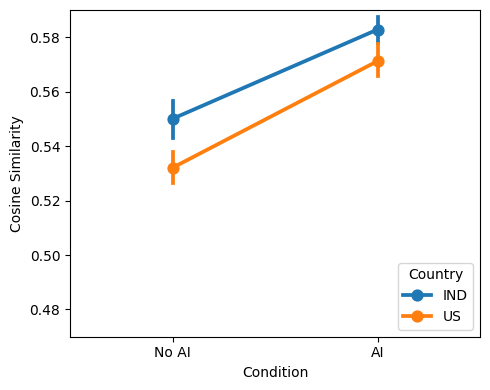

In [60]:
plt.figure(figsize=(5, 4))
sns.pointplot(x='group', y='similarity', hue='country', data=sim_df_intra, order=[CONTROL_LABEL, TREATMENT_LABEL])
# plt.title('How similarly to each other do people write? (intra-group similarity)')
plt.xlabel('Condition')
plt.ylabel('Cosine Similarity')
plt.ylim(0.47, 0.59)
plt.legend(title='Country', loc='lower right')
plt.tight_layout()
plt.savefig('plots/intra_group_similarity_pointplot.png')
plt.show()

In [ ]:
a = sim_df_intra[(sim_df_intra['country'] == 'US') & (sim_df_intra['group'] == CONTROL_LABEL) ]['similarity']
b = sim_df_intra[(sim_df_intra['country'] == 'US') & (sim_df_intra['group'] == TREATMENT_LABEL)]['similarity']
sns.kdeplot(a, label='No AI')
sns.kdeplot(b, label='AI')
plt.legend()
plt.show()

print(stats.ttest_ind(b, a))
utils.cohens_d(b, a)

In [ ]:
test = utils.perform_statistical_test(sim_df_intra[sim_df_intra.country == 'IND'], ['similarity'], filter_col='group', filter_vals=groups, test_name='ttest')
display(test)
test = utils.perform_statistical_test(sim_df_intra[sim_df_intra.country == 'US'], ['similarity'], filter_col='group', filter_vals=groups, test_name='ttest')
display(test)

In [ ]:
# Difference-in-Differences (DiD) Analysis

import statsmodels.formula.api as smf

# Create necessary variables for DiD
sim_df_intra['ai_treatment'] = sim_df_intra['group'].apply(lambda x: 1 if x == 'AI' else 0)
sim_df_intra['country_ind'] = sim_df_intra['country'].apply(lambda x: 1 if x == 'IND' else 0)
sim_df_intra['interaction'] = sim_df_intra['ai_treatment'] * sim_df_intra['country_ind']

# Fit the DiD model
model = smf.ols('similarity ~ ai_treatment + country_ind + interaction', data=sim_df_intra).fit()
print(model.summary())

### Cross-group similarity -- Predictive Model

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def train_and_evaluate_with_k_fold(X, y, n_splits):

    # Use StratifiedKFold for consistent splits across the class distribution
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracies = []
    f1scores = []
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train a logistic regression classifier
        model = LogisticRegression()
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        f1score = f1_score(y_test, y_pred, average='macro')
        accuracies.append(accuracy)
        f1scores.append(f1score)
    
    return accuracies, f1scores

In [4]:
# Function to train and evaluate model multiple times
def train_and_evaluate_for_group(df, group_label, n_splits, subset_features=None):
    # Filter the data based on the group (AI or No AI)
    data = df[df['group'] == group_label]
    
    # Prepare the data
    X = np.vstack(data['embedding'].values)
    y = ((data['country'] == 'US').astype(int)).to_numpy()  # Binary label: 1 for US, 0 for IND
    
    acc = []
    f1 = []

    num_repetitions = 10
    if subset_features is None:
        num_repetitions = 1

    for _ in range(num_repetitions):
        # Pick subset_features random features from X
        if subset_features is not None:
            X = X[:, np.random.choice(X.shape[1], subset_features, replace=False)]
        accuracies, f1scores = train_and_evaluate_with_k_fold(X, y, n_splits)
        acc.extend(accuracies)
        f1.extend(f1scores)

    return acc, f1

def print_results_of_predictive_analysis(accuracy_no_ai, accuracy_ai, f1scores_no_ai, f1scores_ai):
    # Accuracy scores
    print("Accuracy:")
    print(f"Mean accuracy No AI: {np.mean(accuracy_no_ai):.3f}")
    print(f"Mean accuracy AI: {np.mean(accuracy_ai):.3f}")

    # Check if the accuracy scores are normally distributed
    print(stats.shapiro(accuracy_no_ai))
    print(stats.shapiro(accuracy_ai))

    # Since not normal, use Wilcoxon signed-rank test (non-parametric)
    from scipy.stats import ttest_ind
    print(ttest_ind(accuracy_no_ai, accuracy_ai))
    print(utils.cohens_d(accuracy_no_ai, accuracy_ai))

    print("\nF1:")

    print(f"Mean F1 No AI: {np.mean(f1scores_no_ai):.3f}")
    print(f"Mean F1 AI: {np.mean(f1scores_ai):.3f}")

    # Check if the accuracy scores are normally distributed
    print(stats.shapiro(f1scores_no_ai))
    print(stats.shapiro(f1scores_ai))

    # Since not normal, use Wilcoxon signed-rank test (non-parametric)
    from scipy.stats import ttest_ind
    print(ttest_ind(f1scores_no_ai, f1scores_ai))
    print(utils.cohens_d(f1scores_no_ai, f1scores_ai))

In [ ]:
# Build and test models for both AI and No AI groups
df = dfp.copy()
k = 20
accuracy_no_ai, f1scores_no_ai = train_and_evaluate_for_group(df, CONTROL_LABEL, n_splits=k)
accuracy_ai, f1scores_ai = train_and_evaluate_for_group(df, TREATMENT_LABEL, n_splits=k)

print_results_of_predictive_analysis(accuracy_no_ai, accuracy_ai, f1scores_no_ai, f1scores_ai)

In [ ]:
# Run the experiment for both AI and No AI groups for specific tasks
k = 5
df = dfp.copy()
task_id = 'leave'
accuracy_no_ai, f1scores_no_ai = train_and_evaluate_for_group(df[df.id == task_id], CONTROL_LABEL, n_splits=k)
accuracy_ai, f1scores_ai = train_and_evaluate_for_group(df[df.id == task_id], TREATMENT_LABEL, n_splits=k)

print_results_of_predictive_analysis(accuracy_no_ai, accuracy_ai, f1scores_no_ai, f1scores_ai)

In [ ]:
dfp.groupby(['id', 'group']).size()

In [5]:
# Incrementally try different number of dimensions
k = 20
df = dfp.copy()

from tqdm import tqdm
rows = []
for num_dim in tqdm(range(12, 3073, 10)):
    accuracy_no_ai, f1scores_no_ai = train_and_evaluate_for_group(df, CONTROL_LABEL, n_splits=k, subset_features=num_dim)
    accuracy_ai, f1scores_ai = train_and_evaluate_for_group(df, TREATMENT_LABEL, n_splits=k, subset_features=num_dim)

    rows_from_this_run = [(num_dim, CONTROL_LABEL, acc, f1) for acc, f1 in zip(accuracy_no_ai, f1scores_no_ai)]
    rows.extend(rows_from_this_run)
    rows_from_this_run = [(num_dim, TREATMENT_LABEL, acc, f1) for acc, f1 in zip(accuracy_ai, f1scores_ai)]
    rows.extend(rows_from_this_run)

100%|██████████| 307/307 [09:43<00:00,  1.90s/it]


In [6]:
dfr = pd.DataFrame(rows, columns=['num_dim', 'group', 'acc', 'f1'])

<Axes: xlabel='num_dim', ylabel='f1'>

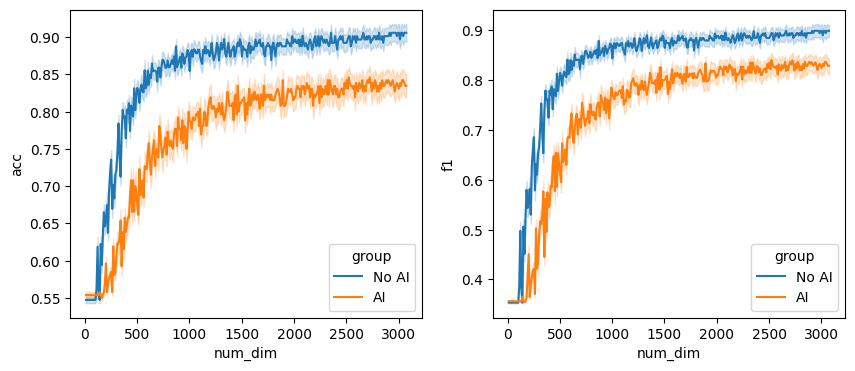

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

sns.lineplot(data=dfr, x='num_dim', y='acc', hue='group', ax=axs[0])
sns.lineplot(data=dfr, x='num_dim', y='f1', hue='group', ax=axs[1])

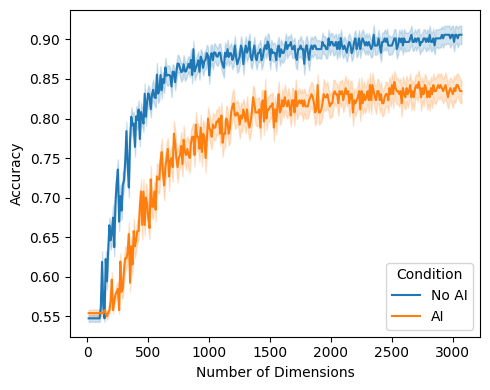

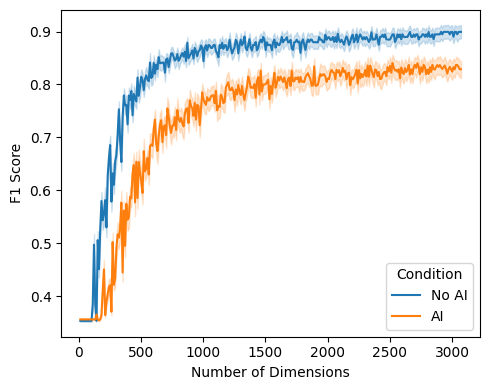

In [8]:
plt.figure(figsize=(5, 4))
sns.lineplot(data=dfr, x='num_dim', y='acc', hue='group')
plt.xlabel('Number of Dimensions')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.legend(title='Condition')
plt.savefig('plots/accuracy_vs_num_dim.png')
plt.show()

plt.figure(figsize=(5, 4))
sns.lineplot(data=dfr, x='num_dim', y='f1', hue='group')
plt.ylabel('F1 Score')
plt.xlabel('Number of Dimensions')
plt.tight_layout()
plt.legend(title='Condition')
plt.savefig('plots/f1_vs_num_dim.png')
plt.show()

### Cross-group similarity -- Cosine Similarity

In [50]:
# Compute similarity scores for inter-group comparisons (India vs US)
ind_us_no_ai = []
ind_us_ai = []
ind_ai_us_no_ai = []
ind_no_ai_us_ai = []

for task_id in dfp['id'].unique():
    dft = dfp[dfp['id'] == task_id]
    indians_wo_ai = np.vstack(dft[(dft['country'] == 'IND') & (dft['group'] == CONTROL_LABEL)]['embedding'].values)
    indians_w_ai = np.vstack(dft[(dft['country'] == 'IND') & (dft['group'] == TREATMENT_LABEL)]['embedding'].values)
    americans_wo_ai = np.vstack(dft[(dft['country'] == 'US') & (dft['group'] == CONTROL_LABEL)]['embedding'].values)
    americans_w_ai = np.vstack(dft[(dft['country'] == 'US') & (dft['group'] == TREATMENT_LABEL)]['embedding'].values)
    
    ind_us_no_ai.extend(cosine_similarity(indians_wo_ai, americans_wo_ai).flatten())
    ind_us_ai.extend(cosine_similarity(indians_w_ai, americans_w_ai).flatten())
    ind_ai_us_no_ai.extend(cosine_similarity(indians_w_ai, americans_wo_ai).flatten())
    ind_no_ai_us_ai.extend(cosine_similarity(indians_wo_ai, americans_w_ai).flatten())

In [51]:
print(np.mean(ind_us_no_ai), np.std(ind_us_no_ai))
print(np.mean(ind_us_ai), np.std(ind_us_ai))
print(np.mean(ind_ai_us_no_ai), np.std(ind_ai_us_no_ai))
print(np.mean(ind_no_ai_us_ai), np.std(ind_no_ai_us_ai))

0.48467851802327067 0.10721479678369351
0.5369284617820334 0.1268065682009553
0.5097390807259491 0.1147666228957161
0.4977203080985018 0.1106740129395247


In [52]:
# The distribution is clearly normal-looking, so we can use a t-test
stats.ttest_ind(ind_us_no_ai, ind_us_ai), utils.cohens_d(ind_us_no_ai, ind_us_ai)

(TtestResult(statistic=-17.88907872670009, pvalue=5.2139619171385356e-70, df=6958.0),
 -0.4377011973670266)

In [53]:
# The distribution is clearly normal-looking, so we can use a t-test
stats.ttest_ind(ind_us_no_ai, ind_ai_us_no_ai), utils.cohens_d(ind_us_no_ai, ind_ai_us_no_ai)

(TtestResult(statistic=-9.159445802992627, pvalue=6.743999269418603e-20, df=6958.0),
 -0.2241088239610983)

(TtestResult(statistic=-9.159445802992627, pvalue=6.743999269418603e-20, df=6958.0),
 -0.2241088239610983)

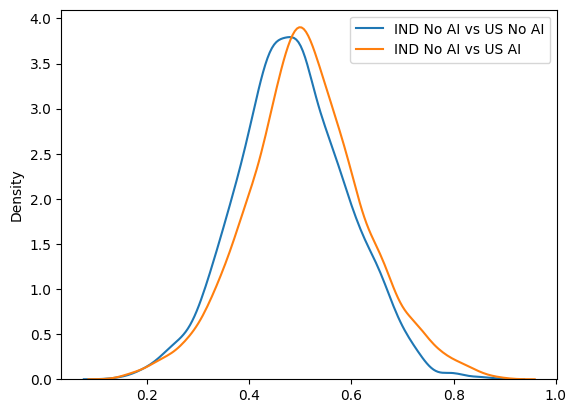

In [54]:
# Check normality by plotting the distributions
sns.kdeplot(ind_us_no_ai, label='IND No AI vs US No AI')
sns.kdeplot(ind_ai_us_no_ai, label='IND No AI vs US AI')
plt.legend()
stats.ttest_ind(ind_us_no_ai, ind_ai_us_no_ai), utils.cohens_d(ind_us_no_ai, ind_ai_us_no_ai)

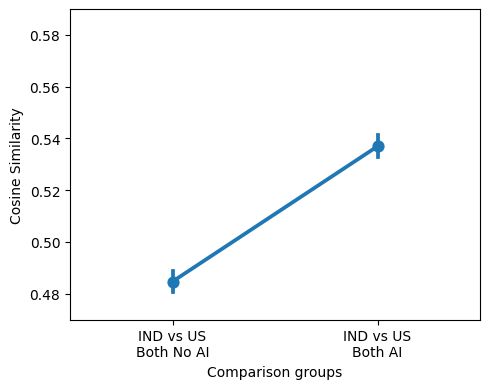

In [58]:
dft1 = pd.DataFrame(ind_us_no_ai)
dft1['group'] = 'IND vs US\nBoth No AI'
dft2 = pd.DataFrame(ind_us_ai)
dft2['group'] = 'IND vs US\nBoth AI'
dft = pd.concat([dft1, dft2])
dft.columns = ['similarity', 'group']
plt.figure(figsize=(5, 4))
sns.pointplot(x='group', y='similarity', data=dft)
# plt.title('Cross-Cultural Similarity between Indian and American Writing')
plt.ylabel('Cosine Similarity')
plt.ylim(0.47, 0.59)
plt.xlabel('Comparison groups')
plt.tight_layout()
plt.savefig('plots/inter_group_similarity_pointplot.png')
plt.show()

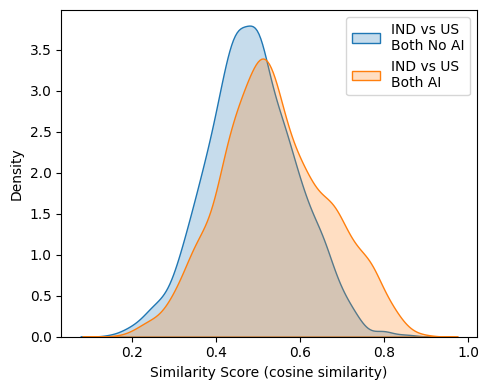

In [57]:
plt.figure(figsize=(5, 4))
sns.kdeplot(data=dft[dft['group'] == 'IND vs US\nBoth No AI']['similarity'], label='IND vs US\nBoth No AI', fill=True)
sns.kdeplot(data=dft[dft['group'] == 'IND vs US\nBoth AI']['similarity'], label='IND vs US\nBoth AI', fill=True)
# plt.title('Density Plot of Cross-Cultural Similarity Scores')
plt.xlabel('Similarity Score (cosine similarity)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig('plots/inter_group_similarity_densityplot.png')
plt.show()

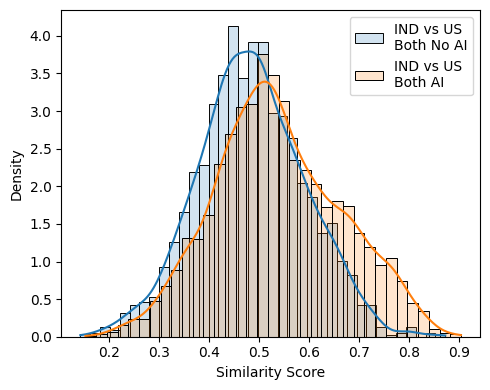

In [24]:
plt.figure(figsize=(5, 4))
sns.histplot(data=dft[dft['group'] == 'IND vs US\nBoth No AI']['similarity'], label='IND vs US\nBoth No AI', fill=True, alpha=0.2, kde=True, stat='density')
sns.histplot(data=dft[dft['group'] == 'IND vs US\nBoth AI']['similarity'], label='IND vs US\nBoth AI', fill=True, alpha=0.2, kde=True, stat='density')
# plt.title('Density Plot of Cross-Cultural Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

### Content analysis

In [4]:
dfe = dfp[dfp.id == 'leave'].copy()

In [5]:
# Check out the initial greetings
dfe['greeting'] = dfe['finalHtml_stripped'].apply(lambda x: (x.split()[0]).lower())
dfe.groupby(['country', 'group'])['greeting'].apply(lambda x: pd.Series(x).value_counts().head(5))

country  group           
IND      AI     dear         10
                i            10
                hello         3
                subject:      3
                respected     3
         No AI  dear          8
                respected     5
                hello         4
                hi            3
                hi,           1
US       AI     dear         10
                i             7
                hey           2
                hello,        2
                hello         1
         No AI  dear         11
                good          3
                i             2
                hello         2
                hi,           2
Name: greeting, dtype: int64

In [6]:
# ngrams in the emails
def compute_ngrams(essays, n):
    ngrams = []
    for essay in essays:
        ngrams_essay = utils.find_ngrams(essay.lower(), n, remove_stopwords=True if n == 1 else False)
        ngrams = [ng for ng in ngrams_essay if ng not in ['leave', 'request', 'two-week']]
        ngrams.extend(ngrams_essay)
    return ngrams

dfe.groupby(['country', 'group'])['finalHtml_stripped'].apply(lambda x: pd.Series(compute_ngrams(x, 1)).value_counts().head(5))

country  group               
IND      AI     hope             4
                sincerely        4
                're              2
                name             2
                grant            2
         No AI  would            6
                week             4
                bed              4
                bangalore        4
                aunt             4
US       AI     understanding    4
                need             2
                take             2
                thank            2
                regularly        2
         No AI  september        6
                advance          4
                dear             2
                mr.              2
                consideration    2
Name: finalHtml_stripped, dtype: int64

In [19]:
# export all essays and their artifacts into an excel file
df_artifacts = []
for task_id in ['festival', 'food', 'public_figure']:
    dft = structured.extract_structured_data_from_tasks(task_id, dfp[dfp['id'] == task_id], model, quiet=False)
    dft = dft.reset_index(names='user_id')
    dft['id'] = task_id
    df_artifacts.append(dft)

df_artifacts = pd.concat(df_artifacts)

118it [00:00, 5776.06it/s]
118it [00:00, 2326.78it/s]
118it [00:00, 6644.13it/s]


In [28]:
dft = dfp.merge(df_artifacts, on=['user_id', 'id'], how='left').copy()
dft[['id', 'country', 'group', 'user_id', 'finalHtml_stripped', 'name']].sort_values(by=['id', 'country', 'group'], ascending=[True, True, False]).rename(columns={'finalHtml_stripped': 'essay', 'name': 'artifact'}).to_csv('data/essays.csv', index=False)

### Save essays with AI suggestions highlighted

I had exported all the essays into a Google sheet including the artifacts extracted above and manually corrected the artifacts.
Now, I needed to highlight the AI suggestions in the essays. So if I started from scratch again, I would lose all the corrections I made to the artifacts.
So I downloaded that Google sheet, and then used the following code to highlight the AI suggestions and then uploaded it back to Google Sheets.

In [43]:
def highlight_ai_suggestions(row, suggestions):
    """
    Returns the essay with AI suggestions highlighted in HTML format
    """
    if row['group'] == CONTROL_LABEL:
        return row['finalHtml_stripped']
    
    essay = row['finalHtml_stripped']
    # Get accepted suggestions for this user/task
    user_suggestions = suggestions[
        (suggestions['user_id'] == row['user_id']) & 
        (suggestions['task_id'] == row['id']) &
        (suggestions['is_accepted'] == True)
    ]
    
    # Sort suggestions by time_shown to process in order
    user_suggestions = user_suggestions.sort_values('time_shown')
    
    # Replace each suggestion with highlighted version
    for _, suggestion in user_suggestions.iterrows():
        if suggestion['suggestionText'] in essay:
            essay = essay.replace(
                suggestion['suggestionText'],
                f'^{suggestion["suggestionText"]}$'
            )
    
    return essay

# Apply highlighting to AI essays
dfp_highlighted = dfp[['id', 'country', 'group', 'user_id']].copy()
dfp_highlighted['highlighted_essay'] = dfp.apply(
    lambda x: highlight_ai_suggestions(x, suggestions_df), 
    axis=1
)
dfp_highlighted = dfp_highlighted.set_index(['id', 'country', 'group', 'user_id'])

In [47]:
# Read all sheets from the Excel file
sheets = pd.read_excel('data/Essays (for coding).xlsx', sheet_name=None)

for sheet_name, df in sheets.items():
    highlighted_col = df.set_index(['task_id', 'country', 'group', 'user_id']).join(dfp_highlighted, on=['task_id', 'country', 'group', 'user_id'])['highlighted_essay']
    df['essay'] = highlighted_col.values # replace the essay with the highlighted version
    sheets[sheet_name] = df
    df = df.sort_values(by=['task_id', 'country', 'group'], ascending=[True, True, False])

with pd.ExcelWriter('data/Essays (for coding) - highlighted.xlsx') as writer:
    for sheet_name, df in sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)